In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:000m eta -:--:--


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import random

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

2024-01-31 20:48:06.321196: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 20:48:06.354352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 20:48:06.354383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 20:48:06.355370: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 20:48:06.360650: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 20:48:06.361020: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './augmented_split/train/',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1436 images belonging to 20 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './augmented_split/val/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 67 images belonging to 20 classes.


In [5]:
train_dir = "augmented_split/train"
val_dir = "augmented_split/val"
test_dir = "augmented_split/test"

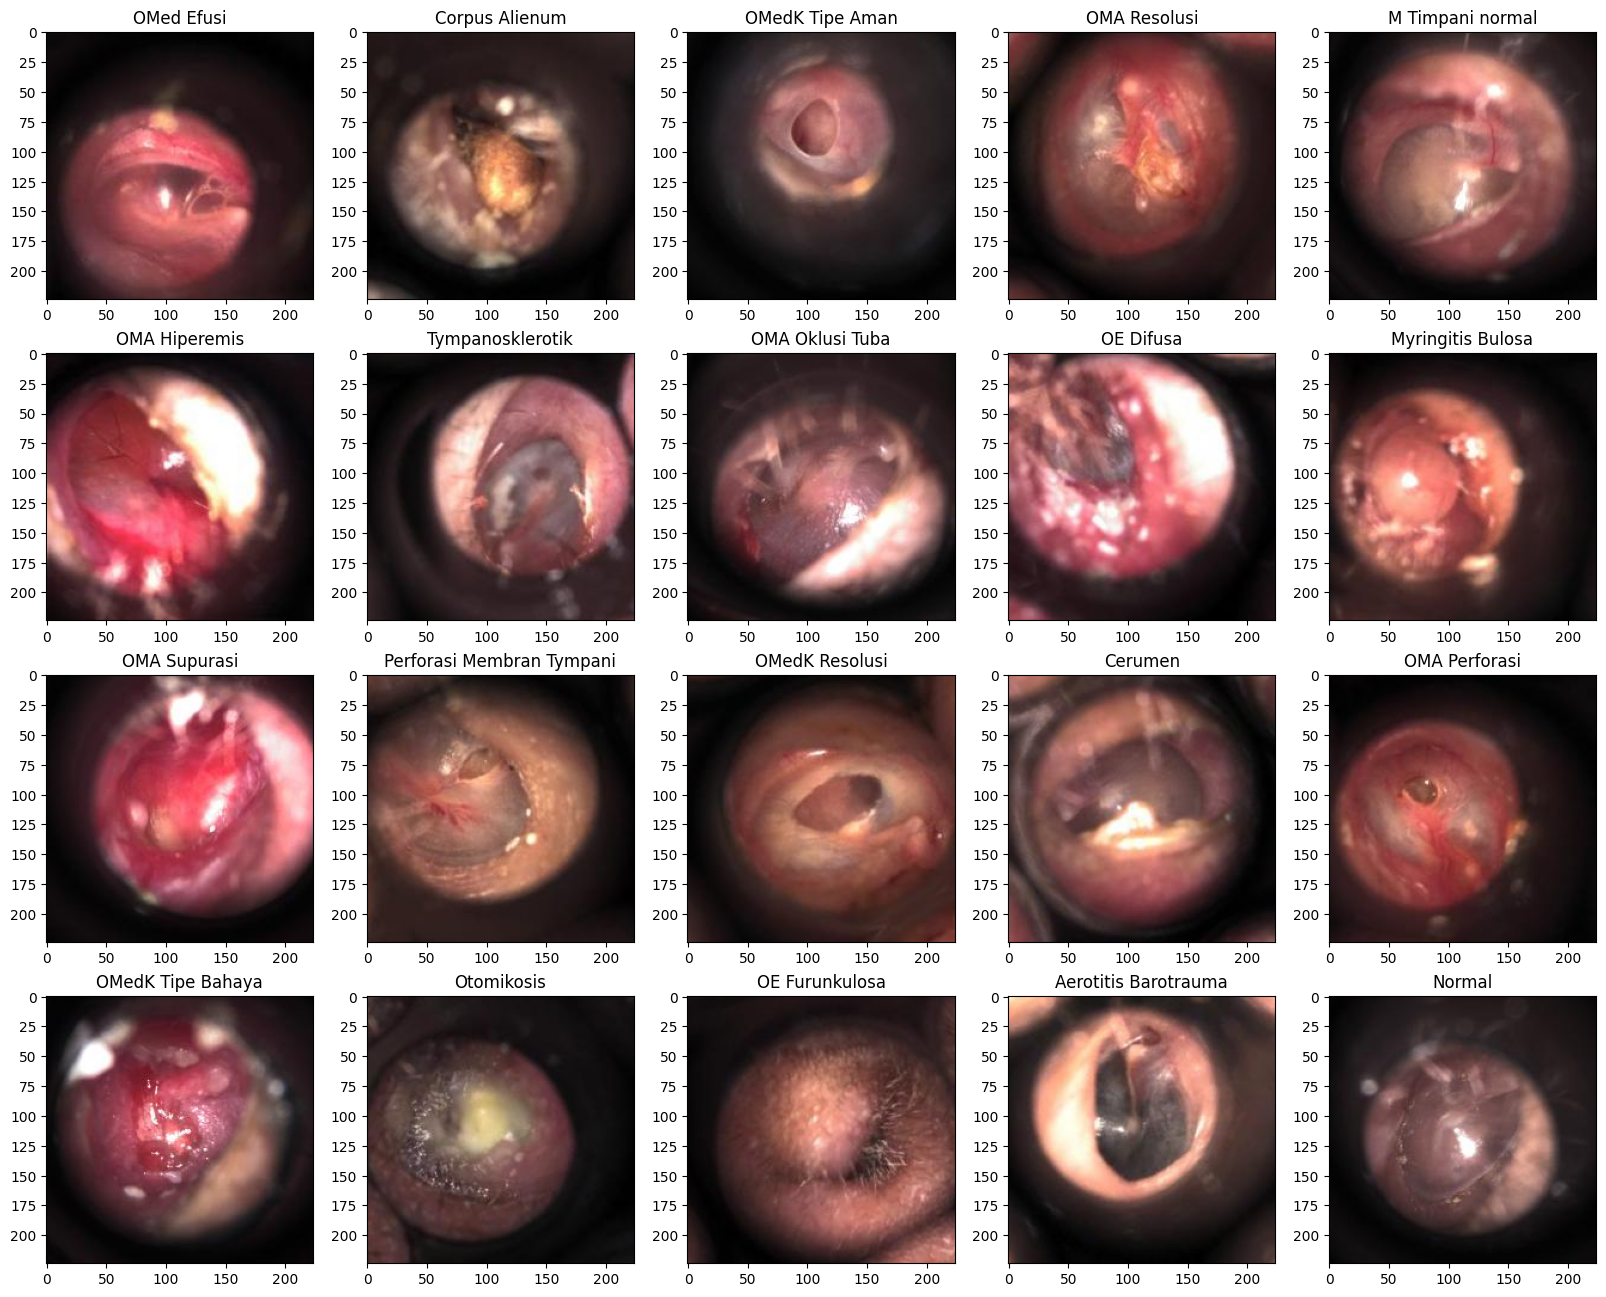

In [6]:
# dataset exploration
# load salah satu citra dari masing masing class yang ada, dan menjadikannya sebagai sebuah tensor
explor_data = []
labels = []
for label in os.listdir(test_dir): #loop masing masing class
  path = test_dir+'/'+label
  img_paths = os.listdir(path)
  random.shuffle(img_paths)
  img_path = path+'/'+img_paths[0]
  img = plt.imread(img_path) #load image
  explor_data.append(img) #masukan citra kedalam list
  labels.append(label) #masukan encoded label kedalam list

explor_data = np.array(explor_data)
explor_data.shape

plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.title(labels[i])
  plt.imshow( explor_data[i] )

In [7]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

2024-01-31 20:48:40.788417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 20:48:40.792708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
for layer in base_model.layers:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(20,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 3, 1280)        0         
 Pooling2D)                                                      
                                                                 
 batch_normalization (Batch  (None, 3, 3, 1280)        5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 3, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                        

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.SGD(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [12]:
filepath = './model_tuning224_128_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 3.6140 - auc: 0.5133
Epoch 1: val_auc improved from -inf to 0.58633, saving model to ./model_tuning224_128_RMSprop1e3.h5


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 38s 1s/step - loss: 3.6140 - auc: 0.5133 - val_loss: 2.9507 - val_auc: 0.5863
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 3.4063 - auc: 0.5585
Epoch 2: val_auc improved from 0.58633 to 0.66105, saving model to ./model_tuning224_128_RMSprop1e3.h5
23/23 [==============================] - 32s 1s/step - loss: 3.4063 - auc: 0.5585 - val_loss: 2.8403 - val_auc: 0.6611
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 3.2433 - auc: 0.5931
Epoch 3: val_auc improved from 0.66105 to 0.71052, saving model to ./model_tuning224_128_RMSprop1e3.h5
23/23 [==============================] - 32s 1s/step - loss: 3.2433 - auc: 0.5931 - val_loss: 2.7873 - val_auc: 0.7105
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 3.1305 - auc: 0.6174
Epoch 4: val_auc improved from 0.71052 to 0.73007, saving model to ./model_tuning224_128_RMSprop1e3.h5
23/23 [==============================] - 31s 1s/step - loss: 3.1

In [14]:
base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]'

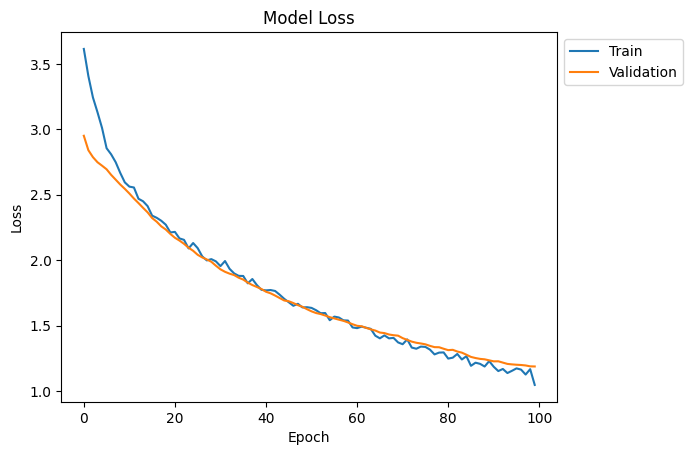

In [15]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

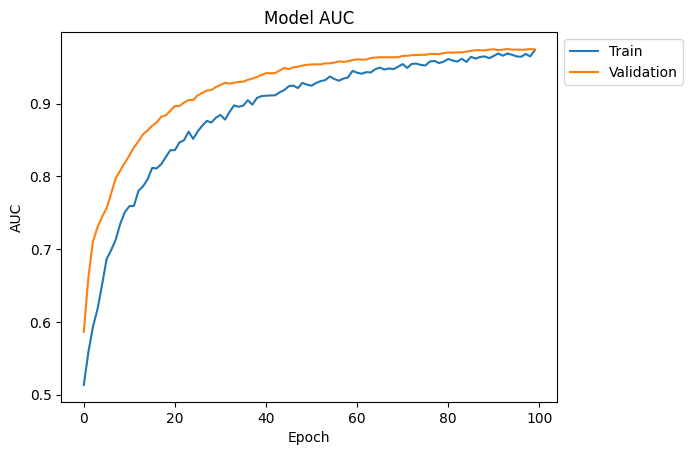

In [16]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

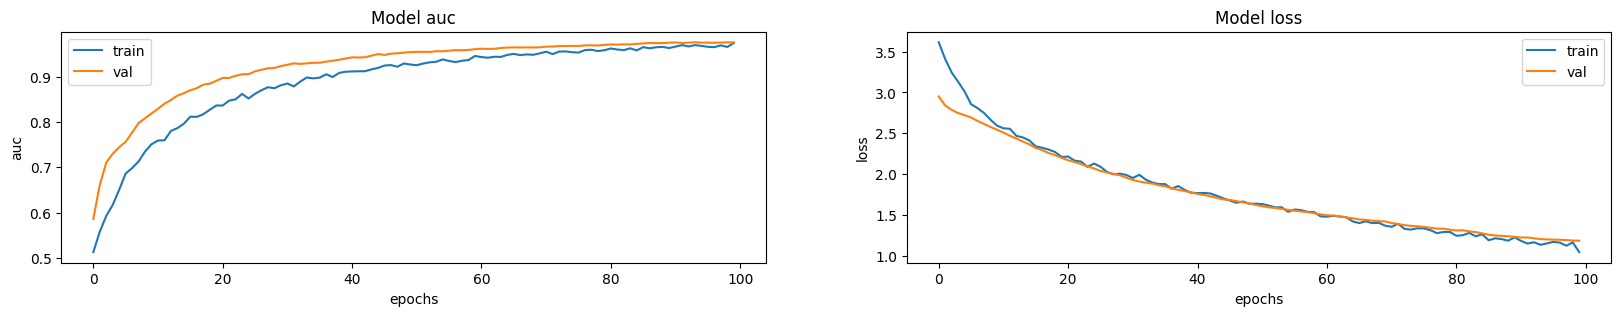

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = './augmented_split/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 401 images belonging to 20 classes.


In [19]:
model.evaluate(test_dataset)

7/7 [==============================] - 9s 1s/step - loss: 1.1323 - auc: 0.9699


[1.1323133707046509, 0.9699496626853943]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.99 % chances are there that the image is NonDemented


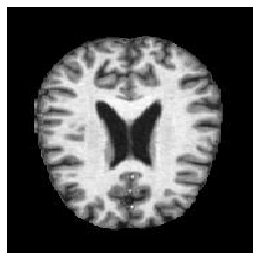

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

72.44 % chances are there that the image is MildDemented


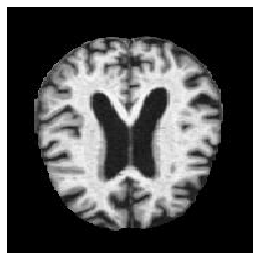

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


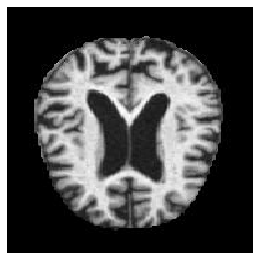

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.99 % chances are there that the image is VeryMildDemented


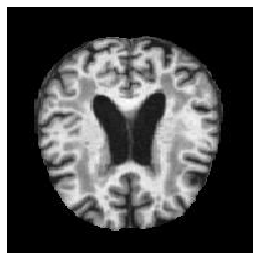

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [37]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [26]:
pred_ls = np.argmax(test_dataset, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

MemoryError: Unable to allocate 36.8 MiB for an array with shape (64, 224, 224, 3) and data type float32